# Kalman filter

Using the same notation as the wikipedia

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
I = np.array([[1,0],[0,1]])

def trans_mat(a,b):
    return a @ b @ a.T

def trans_vec(a,b):
    return a @ b

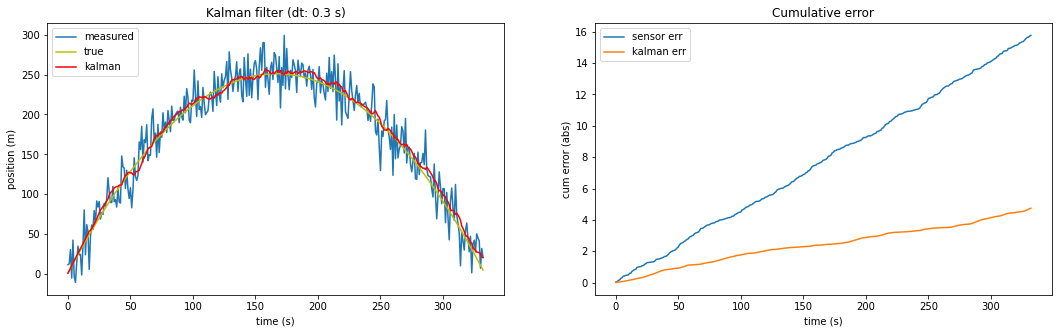

In [17]:
dt = 0.3
pos = 1
vel = 10
acc = -.2

x_true = np.array([pos,vel])

def sample_sensor(x_true):
    #simulate sensor noise
    muV, sigV  = 0, 20
    v = np.random.normal(muV, sigV)    
    R = np.array([[(sigV**2)]]) 

    return (H @ x_true) + v, R

def sample_model_distribution():
    muW,sigW = acc, 1
    w = G*np.random.normal(muW, sigW)
    Q = np.outer(G,G)*(sigW**2)
    return w, Q
        
    
sample_rate = 1.0/dt

# model (x'=Fx+G)
F = np.array([[1,dt],[0,1]])
G = np.array([0.5*dt*dt, dt])

# observation model
H = np.array([[1,0]])   

x_prev = x_true
P_prev = np.array([[1,0],[0,1]]) * 0.1

sensor_err = []
kalman_err = []

pt = []
pm = []
pk = []
for i in range(int(100*sample_rate)):
    pt.append(x_true[0])
    pk.append(x_prev[0])

    # 1) make a noisy measurement using the sensor
    z, R = sample_sensor(x_true)
    pm.append(z[0])

    # 2) make a prediction using the model
    w, Q = sample_model_distribution()
    x_pred = trans_vec(F, x_prev) + ( w )
    P_pred = trans_mat(F, P_prev) + ( Q )

    # compute Kalman gain
    S = trans_mat(H, P_pred) + R
    K = P_pred @ H.T @ np.linalg.inv(S)    
    M = I - (K@H)

    # update state
    x = trans_vec(M, x_pred) + trans_vec(K, z)
    P = trans_mat(M, P_pred) + trans_mat(K, R)

    # track errors

    sensor_err.append(np.abs(x_true - z)[0])
    kalman_err.append(np.abs(x_true - x)[0])

    #step

    # simulate trayectory (for the sensor)
    x_true = trans_vec(F,x_true) + (G*acc)
    x_prev = x
    P_prev = P


fig, axs = plt.subplots(1, 2,figsize=(18,5))
axs[0].set_title(f'Kalman filter (dt: {dt} s)')
axs[0].plot(pm, label="measured")  
axs[0].plot(pt, color = 'y', label="true")    
axs[0].plot(pk, color = 'r', label="kalman")  
axs[0].legend(loc="upper left")
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('position (m)')

axs[1].set_title('Cumulative error')
axs[1].plot(np.cumsum(sensor_err)/ len(sensor_err), label="sensor err")    
axs[1].plot(np.cumsum(kalman_err)/ len(sensor_err), label="kalman err")  
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('cum error (abs)')
axs[1].legend(loc="upper left")
plt.show()

